In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import cv2

# Some general statistics about the dataset

Number of chapters: 212
Number of manga pages: 6262
Total number of patches: 100172


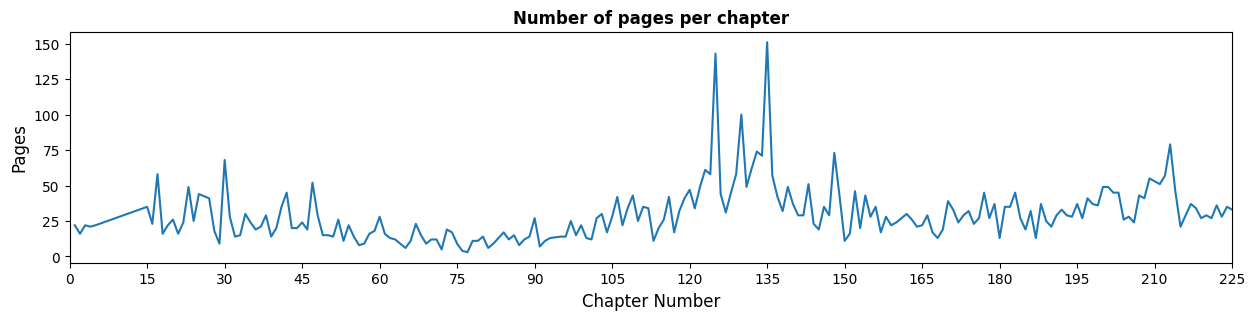

In [2]:
source_dir = 'D:\\OPM\\source\\'
target_dir = 'D:\\OPM\\target\\'

chapters = len(os.listdir(source_dir))
pages = sum(len(files) for subdir, dirs, files in os.walk(source_dir))
page_patches = sum(len(files) for s, d, files in os.walk(target_dir))

print(f'Number of chapters: {chapters}\n'
      f'Number of manga pages: {pages}\n'
      f'Total number of patches: {page_patches}')

chapters = []
pages = []

for subdir in sorted([int(d) for d in os.listdir(source_dir)]):
    chapters.append(subdir)
    pages.append(len(os.listdir(f'{source_dir}{subdir}')))

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(chapters, pages)
ax.set_xlabel('Chapter Number', fontsize=12)
ax.set_ylabel('Pages', fontsize=12)
ax.set_title('Number of pages per chapter', fontsize=12, fontweight='bold')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.set_xlim([0, max(chapters)])
plt.show()

# Dataset insights

**After a visual inspection of the dataset, the following conclusions can be made:**

1. The individual patches of each page have a randomized order, but are not rotated or mirrored.
2. The width of each patch is fixed at 200 pixels. The patch height is varying between either 280 or 312 pixels. Around 15% of the chapters have a patch size of 200 x 312 pixels, while around 85% have a patch height of 280. The size of the patches does not change within a chapter, only between chapters.
3. 4 chapters have no randomized patches and are already in their readable state.
4. 13 chapters contain a single blank page, an entire black page or a few ad pages at the end of the chapter.

**With the above mentioned insights, the following cleaning steps are applied:**

1. The 4 chapters with no randomized pages a will be removed from the dataset.
2. Single blank, entire black pages and pages consisting solely of ads will be removed from the dataset.

Detailed information on the removed chapters and pages can be viewed in the 'dataset_info.csv' file.

The dataset consists, after spliting each page into 16 individual patches, of 100172 images.

**Some thoughts on the dataset**

The problem will now be to find a way to stitch the correct patches together. The patches have no overlapping areas. Therefore algorithms like SIFT (Scale-invariant feature transform) have a hard time finding matching patches. A possible approach could be to interpolate the outer most row/column of each patch to find a fitting candidate. The downside of this approach is, that it is very time consuming and not very efficient. In terms of complexity, we are talking a comparision of each patch with eath other patch of the same page (at least in the worst case scenario). While i am not entirely sure, i suspect we have a complexity of around O(n^2) or even worse.

Furthermore, while we know which 16 patches create a complete page, we don't know what the final page will look like and the patches themselves have no positional label.

So in other words, we have a nice big dataset, but no labels.

I think a possible approach could be an initial grouping of the patches, according to their motive or pixel similarity. From a human viewpoint, solving puzzles involves searching for similarities. Similar colors, patterns, and so on. Therefore the spatial component, or the bigger picture of the patches is important and could be helpful.

# Brute force or classical approach: Euclidean Distance

We know, that each page is made up of 16 image patches. If we look at the problem on a smaller scale, we are trying to find matching patches.
The necessary steps are:
1. Select a patch as a starting point (maybe with some "unique" feature).
2. Search for another patch with a matching pattern.
3. If the patch is correct, search for the next part with a similar pattern.

Especially step 2. is of interest. How do we define a "matching pattern"? On the high level, we search again for similar features. That can be for example textures or shapes. On the lower level, we are looking at the border region of the patch and look if any other part has a similar feature. 

The question we are asking ourselve is: 
Is the outer right edge of patch A similar to the outer left edge of patch B?

We can translate this step by using statistics. An image is nothing more than an array (or matrix). In mathematics exists the so called Euclidean Distance, which measures the similarity of two arrays.

Text(0.5, 1.0, 'Patch B')

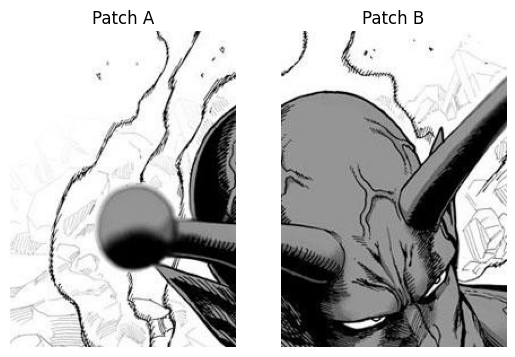

In [22]:
patch_A = cv2.imread('D:\\OPM\\target\\1\\5_0.jpeg', cv2.IMREAD_COLOR)
patch_B = cv2.imread('D:\\OPM\\target\\1\\5_4.jpeg', cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.array(patch_A))
ax[0].axis('off')
ax[0].set_title('Patch A')
ax[1].imshow(np.array(patch_B))
ax[1].axis('off')
ax[1].set_title('Patch B')

In [24]:
#Convert the 3 channel image to a one channel grayscale, because we need one vector.
patch_A_gray = cv2.cvtColor(patch_A, cv2.COLOR_BGR2GRAY)
patch_B_gray = cv2.cvtColor(patch_B, cv2.COLOR_BGR2GRAY)

patch_A_right_edge = patch_A_gray[:, -1]
patch_B_left_edge = patch_B_gray[:, 0]

eucl_dist = np.linalg.norm(patch_A_right_edge - patch_B_left_edge)
print(eucl_dist)

2394.646111641551


On the other hand, if we compare the similarity between the left edge of patch A with the left side of patch B, we should get a higher value, as the euclidean distance increases with a lower similarity between two vectors.

In [25]:
patch_A_left_edge = patch_A_gray[:, 0]
patch_B_left_edge = patch_B_gray[:, 0]

eucl_dist = np.linalg.norm(patch_A_left_edge - patch_B_left_edge)
print(eucl_dist)

2733.8198550745806
